In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# helper function

In [17]:
def pix2norm(shape, pts):
    height, width = shape
    scl = 2.0/(max(height, width))
    offset = np.array([width, height], dtype=pts.dtype).reshape((-1, 1, 2))*0.5
    return (pts - offset) * scl

def keypoints_from_samples(page_outline, span_points):

    all_evecs = np.array([[0.0, 0.0]])
    all_weights = 0

    for points in span_points:

        _, evec = cv2.PCACompute(points.reshape((-1, 2)),
                                 None, maxComponents=1)

        weight = np.linalg.norm(points[-1] - points[0])

        all_evecs += evec * weight
        all_weights += weight

    evec = all_evecs / all_weights

    x_dir = evec.flatten()

    if x_dir[0] < 0:
        x_dir = -x_dir

    y_dir = np.array([-x_dir[1], x_dir[0]])

    pagecoords = cv2.convexHull(page_outline)
    pagecoords = pix2norm((653, 490), pagecoords.reshape((-1, 1, 2)))
    pagecoords = pagecoords.reshape((-1, 2))

    px_coords = np.dot(pagecoords, x_dir)
    py_coords = np.dot(pagecoords, y_dir)

    px0 = px_coords.min()
    px1 = px_coords.max()

    py0 = py_coords.min()
    py1 = py_coords.max()

    p00 = px0 * x_dir + py0 * y_dir
    p10 = px1 * x_dir + py0 * y_dir
    p11 = px1 * x_dir + py1 * y_dir
    p01 = px0 * x_dir + py1 * y_dir

    corners = np.vstack((p00, p10, p11, p01)).reshape((-1, 1, 2))

    ycoords = []
    xcoords = []

    for points in span_points:
        pts = points.reshape((-1, 2))
        px_coords = np.dot(pts, x_dir)
        py_coords = np.dot(pts, y_dir)
        ycoords.append(py_coords.mean() - py0)
        xcoords.append(px_coords - px0)

    return xcoords, np.array(ycoords)

def cubic_func(alpha, beta, x):
    return (alpha + beta) * x**3 - (2 * alpha + beta) * x**2 + alpha * x

def project_points(xs, ys):
    xs_projected, ys_projected = [], []
    for x, y, in zip(xs, ys):
        y = np.array([y] * len(x))
        z = poly(alpha, beta, x)
        
        xyz = np.stack([x, y, z], axis=1)
        xy_projected, _ = cv2.projectPoints(xyz, rvec, tvec, A, np.zeros(5))
        xy_projected = xy_projected.reshape(-1, 2)
        
        xs_projected.append(xy_projected[:, 0])
        ys_projected.append(xy_projected[:, 1])
        
    return xs_projected, ys_projected

# 3d reconstruction plot

In [62]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plot_3d_reconstruction(xs, ys, alpha, beta):
    # page width & height
    w, h = 1.1916, 1.85059
    
    # generate figure
    fig = plt.figure(figsize=(10, 10))
    
    # generate subplot
    ax = fig.add_subplot(projection='3d')
    
    # initialize view angle
    ax.view_init(elev=45, azim=-90)
    
    # generate xy coordinates for page outline
    x = np.linspace(0, w, 20)
    y = np.linspace(0, h, 20)
    z = cubic_func(alpha, beta, x)
    
    # plot page outline
    ax.plot(x, [0] * len(x), z, color='tab:orange') # upper
    ax.plot(x, [h] * len(x), z, color='tab:orange') # bottom
    ax.plot([0] * len(x), y, [z[0]] * len(x), color='tab:orange')  # left
    ax.plot([w] * len(x), y, [z[-1]] * len(x), color='tab:orange') # right
    
    # plot text line in 3d world coordinate
    for x, y in zip(xs, ys):
        # reconstruct page in 3d
        z = cubic_func(alpha, beta, x)
        
        # plot text line
        ax.plot(x, [y] * len(x), z, color='tab:blue')
    
    # get max value for each axis
    xmax = w + 0.5
    ymax = h + 0.5
    zmax = 0.5
    
    # get 3d max coordinates for each axis
    o = np.array([0, 0, 0])
    x = np.array([xmax, 0, 0])
    y = np.array([0, ymax, 0])
    z = np.array([0, 0, zmax])
    
    # prepare text options
    text_options = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 14}
    
    # plot 3d arrow
    for k, v in {'x': x, 'y': y, 'z': z}.items():
        a = Arrow3D([o[0], v[0]], [o[1], v[1]],[o[2], v[2]], mutation_scale=20,  arrowstyle="-|>", color='k')
        ax.add_artist(a)
        ax.text(1.1 * v[0], 1.1 * v[1], 1.1 * v[2], k, **text_options)
    
    # set limit
    ax.set_xlim(0, xmax)
    ax.set_ylim(ymax, 0)
    ax.set_zlim(0, zmax)
    
    # off axis
    ax.set_axis_off()

# load data

In [25]:
span_points = []
for i in range(38):
    span_point = pd.read_csv(f'./span_points/{i}.csv', header=None)
    span_points.append(span_point.values)

page_outline = np.array([[50, 20],
                         [50, 633],
                         [440, 633],
                         [440, 20]])

# get default x, y coordinates

In [26]:
xs, ys = keypoints_from_samples(page_outline, span_points)

In [15]:
alphas = np.linspace(0, 0.5, 5)
betas = np.linspace(0, 0.2, 5)

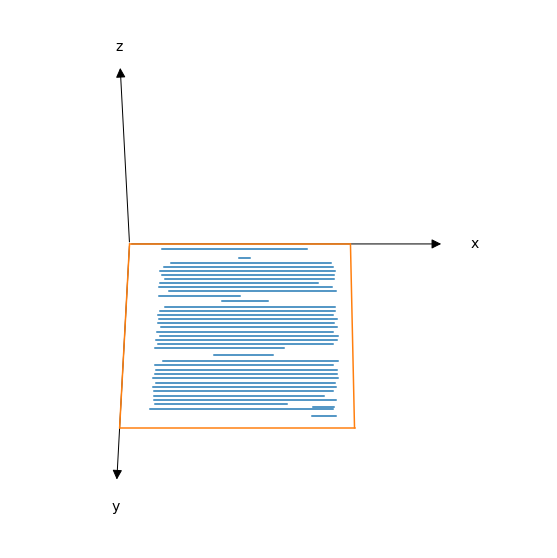

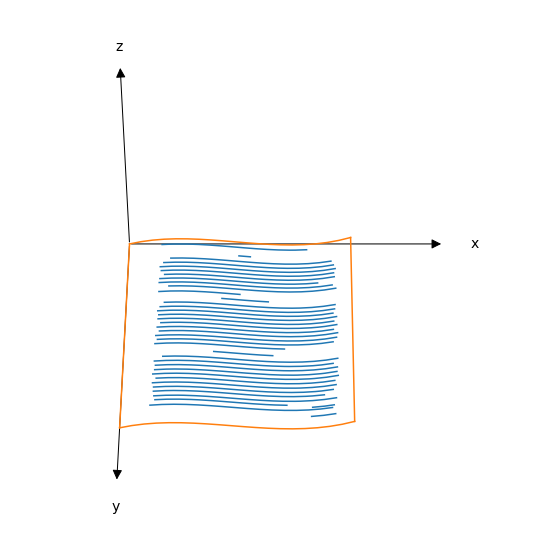

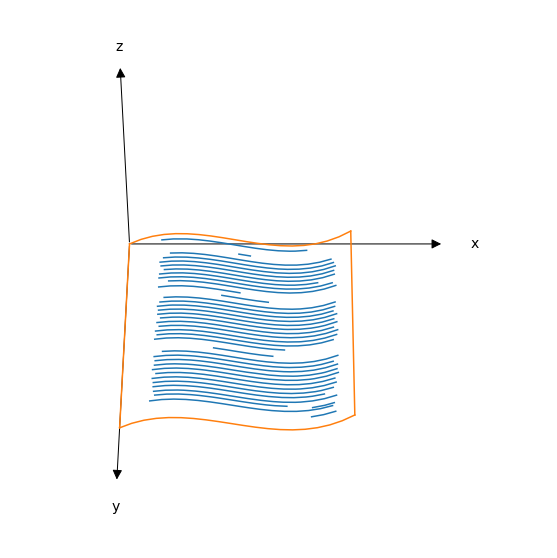

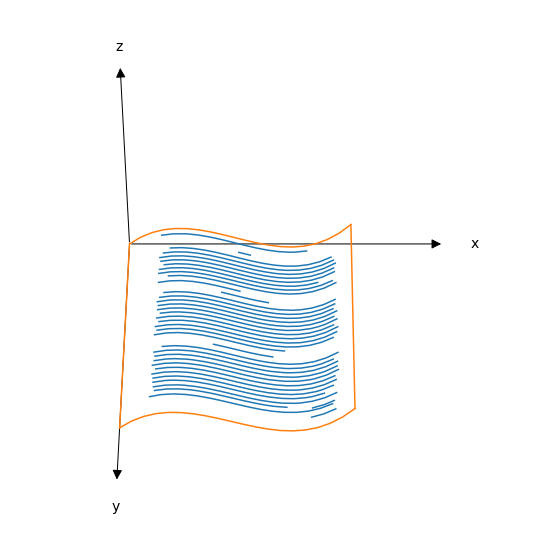

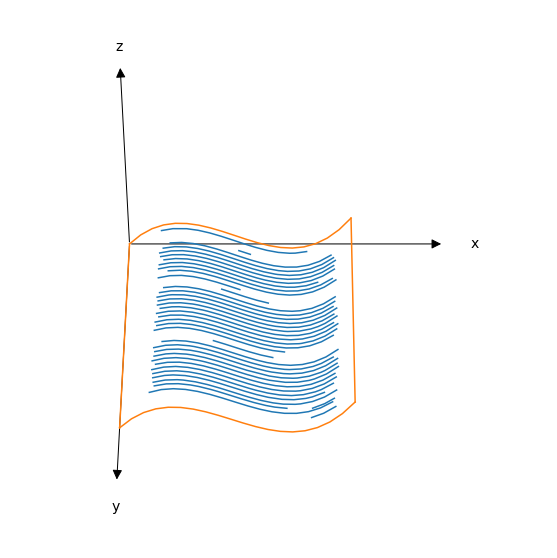

In [63]:
for alpha, beta in zip(alphas, betas):
    plot_3d_reconstruction(xs, ys, alpha, beta)